In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from functions import vac2air_ciddor
from scipy.interpolate import interp1d
from lmfit.models import VoigtModel
from edibles.utils.voigt_profile import voigt_absorption_line
from lmfit import Model
from edibles import PYTHONDIR
from edibles.utils.ContinuumFitter import ContinuumFitter
from edibles.utils.edibles_spectrum import EdiblesSpectrum
from edibles.utils.edibles_oracle import EdiblesOracle
import copy

In [2]:
target = "HD 183143"
no_cloud = 2
min_range = 4000
max_range = 4200
molno = 5

In [3]:
if molno == 1:
    mol = '2MethylNaphthalene'
elif molno == 2:
    mol = 'Acenaphthene'
elif molno == 3:
    mol = 'Benzo_ghi_perylene'
elif molno == 4:
    mol = 'Pentacene'
elif molno == 5:
    mol = 'Perylene'
elif molno == 6:
    mol = 'Phenanthrene'
elif molno == 7:
    mol = 'Pyrene'

In [4]:
pythia = EdiblesOracle()

List=pythia.getFilteredObsList(object=[target], MergedOnly=True, WaveMin=min_range, WaveMax=max_range)
filename = List.tolist()

/home/devotosh01/Western_work/Work/ediblesDR4
***Common Objects***
['HD 183143']
**Filtered File List**
18814    /HD183143/BLUE_437/HD183143_w437_n1_20180907_B...
18836    /HD183143/BLUE_437/HD183143_w437_n2_20180912_B...
Name: Filename, dtype: object
2


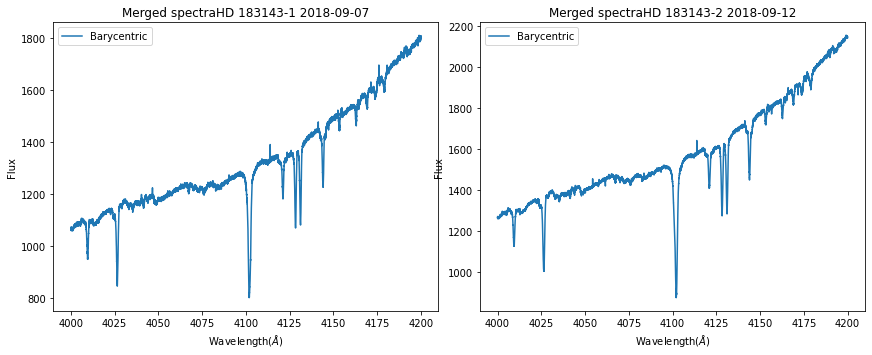

In [5]:
rdata = np.empty(shape=len(filename), dtype=object)
fig1,ax1 = plt.subplots(-((-len(filename))//2),2,figsize=(12,-5*((-len(filename))//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])


for z1,file in enumerate (filename):
    sp = EdiblesSpectrum(file)
    sp.getSpectrum(xmin=min_range, xmax=max_range)
    
    infoarr = np.empty(shape=2, dtype=object)
    infoarr[0] = str(sp.datetime.day)+'/'+str(sp.datetime.month)+'/'+str(sp.datetime.year)
    infoarr[1] = np.array([sp.bary_wave, sp.bary_flux]).transpose()
    
    rdata[z1] = infoarr
    if(len(filename)<3):
        fax1 = ax1[z1]
    else:
         fax1 = ax1[z1//2, z1-2*(z1//2)]   
    
    fax1.plot(sp.bary_wave, sp.bary_flux, label='Barycentric')
    title1 = 'Merged spectra'+target+'-'+str(z1+1) +" "+ str(sp.datetime.date())
    fax1.set_title(title1)
    fax1.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
    fax1.legend()


In [6]:
print(len(rdata))
print(rdata.shape)
print(rdata[1])

2
(2,)
['12/9/2018' array([[4000.01422531, 1269.61828613],
                    [4000.03422408, 1269.54760742],
                    [4000.05422284, 1264.84179688],
                    ...,
                    [4199.94188733, 2141.16064453],
                    [4199.96188609, 2147.20898438],
                    [4199.98188486, 2147.3828125 ]])]


In [7]:
cont_rdata = copy.deepcopy(rdata)

fig2,ax2 = plt.subplots(-((-len(cont_rdata))//2),2,figsize=(12,-5*((-len(cont_rdata))//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for z2 in range(len(cont_rdata)):
    cf1 = ContinuumFitter(rdata[z2][1][:,0], rdata[z2][1][:,1])
    cf11, pts = cf1.SplineManualAnchor()
    cont_rdata[z2][1][:,1] = rdata[z2][1][:,1]/cf11(rdata[z2][1][:,0])
    
    if(len(cont_rdata)<3):
        fax2 = ax2[z2]
    else:
        fax2 = ax2[z2//2, z2-2*(z2//2)]   
    
    fax2.plot(cont_rdata[z2][1][:,0], cont_rdata[z2][1][:,1], label='Barycentric before removal of lines')
    title2 = 'Continuum processed(divided) spectra'+target+'-'+str(z2+1) +" "+ str(sp.datetime.date())
    fax2.set_title(title2)
    fax2.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
    fax2.legend()
    
if not ((len(cont_rdata)-2*(len(cont_rdata)//2))==0):
    fig2.delaxes(ax2[len(cont_rdata)//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

<Figure size 432x288 with 0 Axes>

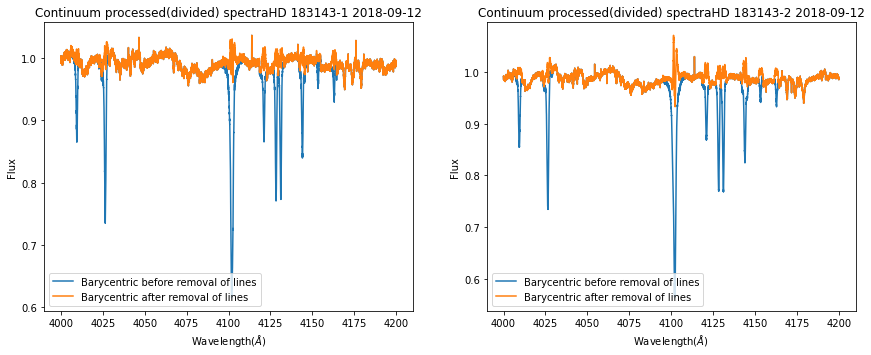

In [8]:
line_rdata = copy.deepcopy(cont_rdata)
sd = 8.770

fig3,ax3 = plt.subplots(-((-len(line_rdata))//2),2,figsize=(12,-5*((-len(line_rdata))//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for z3 in range(len(line_rdata)):
    cf2 = ContinuumFitter(cont_rdata[z3][1][:,0], cont_rdata[z3][1][:,1])
    cf22 = cf2.SelectPoints(n=100, y_message='Select atomic/stellar lines to be removed')[:,0]
    rempeaks = np.reshape(cf22, (int(cf22.size/2),2))
    for i2 in range(rempeaks.shape[0]):
        xfit_m1 = cont_rdata[z3][1][np.logical_and(cont_rdata[z3][1][:,0]>=rempeaks[i2,0], cont_rdata[z3][1][:,0]<=rempeaks[i2,1]),0]
        yfit_m1 = 1 - cont_rdata[z3][1][np.logical_and(cont_rdata[z3][1][:,0]>=rempeaks[i2,0], cont_rdata[z3][1][:,0]<=rempeaks[i2,1]),1]
        mod1 = VoigtModel()
        par1 = mod1.guess(yfit_m1, x=xfit_m1)
        res1 = mod1.fit(yfit_m1, par1, weights=1/sd, x=xfit_m1)
        line_rdata[z3][1][np.logical_and(line_rdata[z3][1][:,0]>=rempeaks[i2,0], line_rdata[z3][1][:,0]<=rempeaks[i2,1]),1] = (1-yfit_m1)/(1-res1.best_fit)

    if(len(line_rdata)<3):
        fax3 = ax3[z3]
    else:
        fax3 = ax3[z3//2, z3-2*(z3//2)]   
    
    fax3.plot(cont_rdata[z3][1][:,0], cont_rdata[z3][1][:,1], label='Barycentric before removal of lines')
    fax3.plot(line_rdata[z3][1][:,0], line_rdata[z3][1][:,1], label='Barycentric after removal of lines')
    
    title3 = 'Continuum processed(divided) spectra'+target+'-'+str(z3+1) +" "+ str(sp.datetime.date())
    fax3.set_title(title3)
    fax3.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
    fax3.legend()
    
if not ((len(line_rdata)-2*(len(line_rdata)//2))==0):
    fig3.delaxes(ax3[len(line_rdata)//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

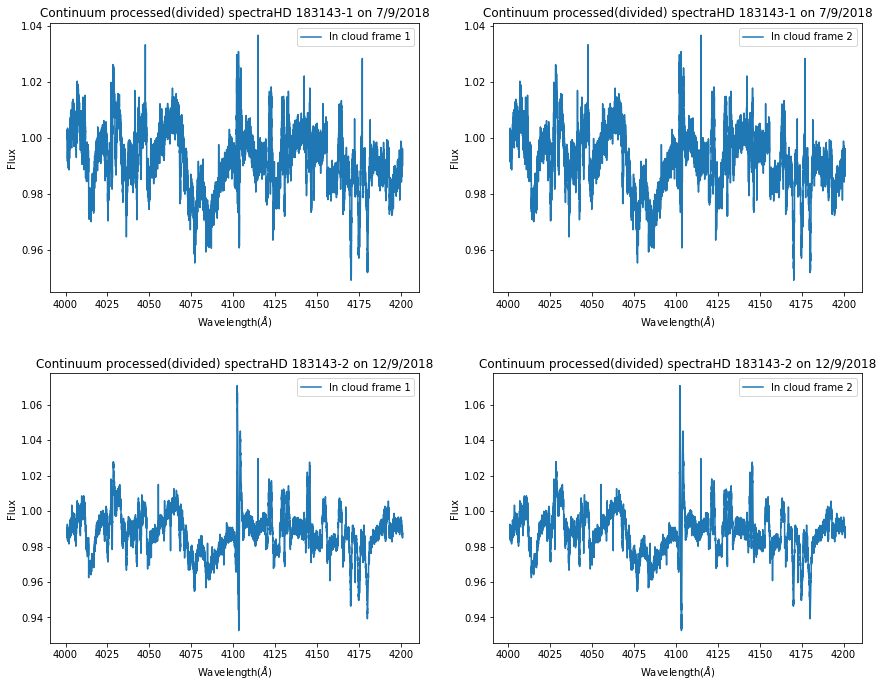

In [9]:
with open('rad_vel_edibles.txt') as f:
    for l in f:
        l = l.split(',')
        
        if (l[0])==target.replace(' ',''):
            vel = l[1].split(';')
            break
            
datas = np.empty(shape=len(vel), dtype = object)
for z4 in range(len(vel)):
    datas[z4] = copy.deepcopy(line_rdata)
    
fig4,ax4 = plt.subplots(-((-len(datas)*len(vel))//2),2,figsize=(12,-5*((-len(datas)*len(vel))//2)))
plt.tight_layout(rect=[0,0.03,1,0.95])

for v1 in range(len(datas)):
    for v2 in range(len(vel)):
        datas[v2][v1][1][:,0] = datas[v2][v1][1][:,0] + (1+(float(vel[v2])/299792.458))
        
        if(len(datas)*len(vel)<3):
            fax4 = ax4[v1*len(vel)+v2]
        else:
            fax4 = ax4[(v1*len(vel)+v2)//2, (v1*len(vel)+v2)-2*((v1*len(vel)+v2)//2)]   
    
        lb = 'In cloud frame '+ str(v2+1)
        fax4.plot(datas[v2][v1][1][:,0], datas[v2][v1][1][:,1], label=lb)        
        title4 = 'Continuum processed(divided) spectra'+target+'-'+str(v1+1) +" on "+ datas[v2][v1][0]
        fax4.set_title(title4)
        fax4.set(xlabel=r'Wavelength($\AA$)',ylabel='Flux')
        fax4.legend()
    
if not ((len(datas)*len(vel)-2*(len(datas)*len(vel)//2))==0):
    fig4.delaxes(ax4[len(datas)*len(vel)//2,1])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

In [10]:
#paramFile = 'C:\\Users\\hkhan\\edibles\edibles\\utils\\Harshit\\Lab Spectra Parameters\\' + molName + 'Params.txt'
#molParam = np.loadtxt(paramFile)

params = "/home/devotosh01/Western_work/Work/Pentacene/"+mol+"Par.txt"
stack_par = np.loadtxt(params)
print(stack_par)
#print(perylene)

[[4.02222396e+03 9.57409857e-01]
 [4.02705568e+03 5.17571119e-01]
 [4.03012720e+03 6.91512997e-01]
 [4.03350429e+03 4.60135470e-01]
 [4.03709557e+03 4.29276290e-01]
 [4.05558409e+03 2.29763924e-01]
 [4.05894203e+03 4.30181205e-01]
 [4.06265053e+03 4.74727336e-01]
 [4.06483289e+03 7.54654108e-01]
 [4.06829041e+03 4.94670567e-01]
 [4.07193795e+03 5.01556542e-01]
 [4.07560763e+03 4.39447347e-01]
 [4.07939478e+03 5.63051315e-01]
 [4.08303576e+03 4.75854186e-01]
 [4.08500697e+03 5.70226308e-01]
 [4.08819726e+03 4.84132741e-01]
 [4.09158214e+03 5.14287493e-01]
 [4.09528660e+03 5.13437592e-01]
 [4.10369338e+03 1.17693872e+00]
 [4.12741077e+03 5.12259279e-01]
 [4.13102459e+03 4.66325390e-01]
 [4.13472563e+03 4.52863874e-01]
 [4.13890048e+03 4.95577472e-01]
 [4.14129375e+03 4.10169290e-01]
 [4.14440603e+03 4.76366395e-01]
 [4.14771586e+03 5.38573460e-01]
 [4.15125900e+03 5.53910938e-01]
 [4.15516923e+03 5.82354469e-01]
 [4.15691900e+03 5.31065528e-01]
 [4.16003799e+03 8.85986012e-01]
 [4.163890

In [22]:
#Function for Spectral stacking, which takes in the input as filename and array having info about start and end points of peak. 

def spectral_stacker_voigt(fdata, peaks):
    
    No_Peaks = peaks.shape[0]
    fDshft = np.empty(shape=No_Peaks, dtype=object)
    
    ffig, faxs = plt.subplots(3, 2, figsize=(12,15))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    faxs[0,0].plot(fdata[:,0], fdata[:,1])
    faxs[0,0].set_title('Lab Spectrum')
    faxs[0,0].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    
    skip = 0
    noskip = np.array([])
    
   
    for i1 in range(No_Peaks):
        temp = fdata[np.logical_and(fdata[:,0]>=peaks[i1,0]-2*peaks[i1,1], fdata[:,0]<=peaks[i1,0]+2*peaks[i1,1]),:]
        if temp.shape[0] == 0 or (np.min(temp[:, 0]) >= peaks[i1, 0] - 0.90*2*peaks[i1, 1]) or (np.max(temp[:, 0]) <= peaks[i1, 0] + 0.90*2*peaks[i1, 1]):
            skip = skip + 1
        else:
            noskip = np.append(noskip,i1)            
            p = 'Peak'+str(i1+1)
            faxs[0,1].plot(temp[:,0], temp[:,1], label=p)
            
            temp2 = temp
            temp2[:,0] = (temp[:,0]-peaks[i1,0])/(peaks[i1,1]/2)
            fDshft[i1-skip] = temp2
            #fDshft[j1-skip][:,0] = (temp[j1][:,0]-peaks[j1,0])/(peaks[j1, 1]/2)
            #fDshft[j1-skip][:,1] = temp[j1][:,1]
            shp = 'Shifted ' + p
            faxs[1, 0].plot(fDshft[i1-skip][:,0], fDshft[i1-skip][:,1], label = shp)
            
            
    faxs[0,1].set_title('Peaks')
    faxs[0,1].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    faxs[0,1].legend()        
    faxs[1,0].set_title('Spectrum with peaks shifted')
    faxs[1,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,0].legend()
    
    fDshft = fDshft[ : No_Peaks - skip]
    fpoints = fDshft[0].shape[0]
    fstart = np.min(fDshft[0][:,0])
    fend = np.max(fDshft[0][:,0])
    
    for k1 in range(fDshft.shape[0]):
        if fDshft[k1].shape[0]>fpoints:
            fpoints = fDshft[k1].shape[0]
        if np.min(fDshft[k1][:,0]) > fstart:
            fstart = np.min(fDshft[k1][:,0])
        if np.max(fDshft[k1][:,0]) < fend:
            fend = np.max(fDshft[k1][:,0])
    fwavelength = np.linspace(fstart, fend, num = fpoints)  
    
            
    fitpn = np.empty(shape=No_Peaks, dtype=object)  
    for l1 in range(fDshft.shape[0]):
        fitpn[l1] = interp1d(fDshft[l1][:,0], fDshft[l1][:,1])
        
        
    ffin = np.zeros((fpoints,2))
    ffin[:,0] = fwavelength
    
    for m1 in range(fDshft.shape[0]):
        ffin[:,1] = ffin[:,1]+(fitpn[m1](fwavelength)/float(fDshft.shape[0]))
        pk1 = 'Peak' +str(m1+1)
        faxs[1,1].plot(fwavelength, fitpn[m1](fwavelength), label=pk1)         
        faxs[2,0].plot(fwavelength, fitpn[m1](fwavelength),label=pk1)
    faxs[1,1].set_title('Interpolated Peaks having same widths')
    faxs[1,1].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,1].legend()
    faxs[2,0].set_title('Interpolated Peaks with the stacked peak')
    faxs[2,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,0].legend()
    
    ind = ffin
    
    faxs[2,0].plot(ffin[:,0], ffin[:,1], label='Stacked spectra')
    faxs[2,0].legend()
    faxs[2,1].plot(ffin[:,0], ffin[:,1], label = 'Final Stacked peak')
    faxs[2,1].set_title('Only Stacked peak')
    faxs[2,1].set(xlabel = 'Relative Wavelength (Å)(shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,1].legend()
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    return ffin

In [27]:
def widthNormLinStacker(fdata2, peakParam2):
    
    P2 = peakParam2.shape[0]
    
    
    #plotting spectrum
    
    ffig2, faxs2 = plt.subplots(3, 2, figsize=(12,15))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    faxs2[0, 0].plot(fdata2[:, 0], fdata2[:, 1], label = 'Spectrum')
    
    faxs2[0, 0].set_title('Full spectrum')
    faxs2[0, 0].set(xlabel = 'Wavelength in Å', ylabel = 'Relative intensity')
    faxs2[0, 0].legend()
    
    
    #extracting peaks
    
    fpdshifted2 = np.empty(shape = P2, dtype = object)
    skipper1 = 0
    nonSkip = np.array([])
    
    for i2 in range(P2):
        #extracting wavelengths and intensities within ranges given by peakParam2
        #total width of peak is being taken to be 4*FWHM
        tbc1 = fdata2[np.logical_and(fdata2[:, 0]>=peakParam2[i2, 0]-2*peakParam2[i2, 1]
                                     , fdata2[:, 0]<=peakParam2[i2, 0]+2*peakParam2[i2, 1]), :]
        
        #if it does not find 90% of the wavelengths in a peak's range, it skips that peak
        if tbc1.shape[0] == 0 or (np.min(tbc1[:, 0]) >= peakParam2[i2, 0] - 0.90*2*peakParam2[i2, 1]) or (np.max(tbc1[:, 0]) <= peakParam2[i2, 0] + 0.90*2*peakParam2[i2, 1]):
            #print('Range ' + str(peakParam2[i2, 0]) + ' to ' + str())
            skipper1 = skipper1 + 1
        else:
            nonSkip = np.append(nonSkip, i2)
            pkLbl2 = 'Just peak ' + str(i2+1)
            faxs2[0, 1].plot(tbc1[:, 0], tbc1[:, 1], label = pkLbl2)
            
            #shifting the above peaks by central value and dividing by FWHM/2
            tbc2 = tbc1
            tbc2[:, 0] = (tbc1[:, 0] - peakParam2[i2, 0])/(peakParam2[i2, 1]/2)
            fpdshifted2[i2 - skipper1] = tbc2
            shPkLbl2 = 'Shifted peak ' + str(i2+1)
            faxs2[1, 0].plot(fpdshifted2[i2 - skipper1][:, 0], fpdshifted2[i2 - skipper1][:, 1], label = shPkLbl2)
    
    faxs2[0, 1].set_title('Spectrum with just peaks')
    faxs2[0, 1].set(xlabel = 'Wavelength in Å', ylabel = 'Relative intensity')
    #faxs2[0, 1].legend()
    
    faxs2[1, 0].set_title('Spectrum with peaks shifted')
    faxs2[1, 0].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
    #faxs2[1, 0].legend()
    
    fpdshifted2 = fpdshifted2[ : P2 - skipper1]
    #print(skipper1)
    #print(fpdshifted2.shape)
    
    #calculating no of points, wavelength ranges and corresponding equally distributed wavelengths
    
    fnosPoints2 = fpdshifted2[0].shape[0]
    #minWave2 = peakParam2[0][0]-peakParam2[0][1]
    #maxWave2 = peakParam2[0][2]-peakParam2[0][1]
    minWave2 = np.min(fpdshifted2[0][:, 0])
    maxWave2 = np.max(fpdshifted2[0][:, 0])
    
    for k2 in range(fpdshifted2.shape[0]):
        #print('Peak ' + str(nonSkip[k2]) + ' - ' + str(np.min(fpdshifted2[k2][:, 0])) + ' to ' + str(np.max(fpdshifted2[k2][:, 0])))
        if fpdshifted2[k2].shape[0] > fnosPoints2:
            fnosPoints2 = fpdshifted2[k2].shape[0]
        if np.min(fpdshifted2[k2][:, 0]) > minWave2:
            minWave2 = np.min(fpdshifted2[k2][:, 0])
        if np.max(fpdshifted2[k2][:, 0]) < maxWave2:
            maxWave2 = np.max(fpdshifted2[k2][:, 0])
    fwavelengths2 = np.linspace(minWave2, maxWave2, num = fnosPoints2)
    
    
    #interpolation
    
    ffa2 = np.empty(shape = fpdshifted2.shape[0], dtype = object)
    
    for l2 in range(fpdshifted2.shape[0]):
        ffa2[l2] = interp1d(fpdshifted2[l2][:, 0], fpdshifted2[l2][:, 1])
    
    
    #plotting interpolated peaks and stacked peak
    
    ffinalData2 = np.zeros((fnosPoints2, 2))
    ffinalData2[:, 0] = fwavelengths2
    
    for m2 in range(fpdshifted2.shape[0]):
        tmpHol2 = ffa2[m2](fwavelengths2)
        ffinalData2[:, 1] = ffinalData2[:, 1] + (tmpHol2/float(fpdshifted2.shape[0]))
        lab2 = 'Interpolated peak ' + str(nonSkip[m2]+1)
        faxs2[1, 1].plot(fwavelengths2, tmpHol2, label = lab2)
    
    #print(ffinalData2.shape)
    
    faxs2[1, 1].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Stacked peak')
    
    faxs2[1, 1].set_title('Spectrum with peaks interpolated in calculated range and stacked peak')
    faxs2[1, 1].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
    #faxs2[1, 1].legend()
    
    faxs2[2, 0].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Just stacked peak')
    
    faxs2[2, 0].set_title('Just stacked peak')
    faxs2[2, 0].set(xlabel = 'Shifted and normalised wavelength', ylabel = 'Relative intensity')
    faxs2[2, 0].legend()
    
    ffig2.delaxes(faxs2[2, 1])
    
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    fullTitle2 = 'Plots for stacking'
    plt.suptitle(fullTitle2, size = 18)
    
    #print(ffinalData2.shape)
    return ffinalData2

In [28]:
def observationStacker(obsData, axsInfo):
    
    P2 = len(obsData)
    
    
    #plotting all observations
    
    ffig2, faxs2 = plt.subplots(1, 2, figsize=(12,5))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    for i1 in range(P2):
        obsLab1 = 'Observation ' + str(i1+1)
        faxs2[0].plot(obsData[i1][:, 0], obsData[i1][:, 1], label = obsLab1)
    
    faxs2[0].set_title('All observations')
    
    if axsInfo[0][1] == 'No units':
        xlab1 = axsInfo[0][0]
    else:
        xlab1 = axsInfo[0][0] + ' in ' + axsInfo[0][1]
    
    if axsInfo[1][1] == 'No units':
        ylab1 = axsInfo[1][0]
    else:
        ylab1 = axsInfo[1][0] + ' in ' + axsInfo[1][1]
    
    faxs2[0].set(xlabel = xlab1, ylabel = ylab1)
    faxs2[0].legend()
    
    fnosPoints2 = obsData[0].shape[0]
    #minWave2 = peakParam2[0][0]-peakParam2[0][1]
    #maxWave2 = peakParam2[0][2]-peakParam2[0][1]
    minWave2 = np.min(obsData[0][:, 0])
    maxWave2 = np.max(obsData[0][:, 0])
    
    for k2 in range(P2):
        #print('Peak ' + str(nonSkip[k2]) + ' - ' + str(np.min(fpdshifted2[k2][:, 0])) + ' to ' + str(np.max(fpdshifted2[k2][:, 0])))
        if obsData[k2].shape[0] > fnosPoints2:
            fnosPoints2 = obsData[k2].shape[0]
        if np.min(obsData[k2][:, 0]) > minWave2:
            minWave2 = np.min(obsData[k2][:, 0])
        if np.max(obsData[k2][:, 0]) < maxWave2:
            maxWave2 = np.max(obsData[k2][:, 0])
    
    #print(minWave2)
    #print(maxWave2)
    
    fwavelengths2 = np.linspace(minWave2, maxWave2, num = fnosPoints2)
    
    
    #interpolation
    
    ffa2 = np.empty(shape = P2, dtype = object)
    
    for l2 in range(P2):
        ffa2[l2] = interp1d(obsData[l2][:, 0], obsData[l2][:, 1])
    
    #plotting interpolated peaks and stacked peak
    
    ffinalData2 = np.zeros((fnosPoints2, 2))
    ffinalData2[:, 0] = fwavelengths2
    
    for m2 in range(P2):
        tmpHol2 = ffa2[m2](fwavelengths2)
        ffinalData2[:, 1] = ffinalData2[:, 1] + (tmpHol2/P2)
    
    
    faxs2[1].plot(ffinalData2[:, 0], ffinalData2[:, 1], label = 'Just stacked peak')
    
    faxs2[1].set_title('Just stacked peak')
    faxs2[1].set(xlabel = xlab1, ylabel = ylab1)
    faxs2[1].legend()
    
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    
    fullTitle2 = 'Plots for stacking'
    plt.suptitle(fullTitle2, size = 18)
    
    print(ffinalData2.shape)
    return ffinalData2


(236, 2)


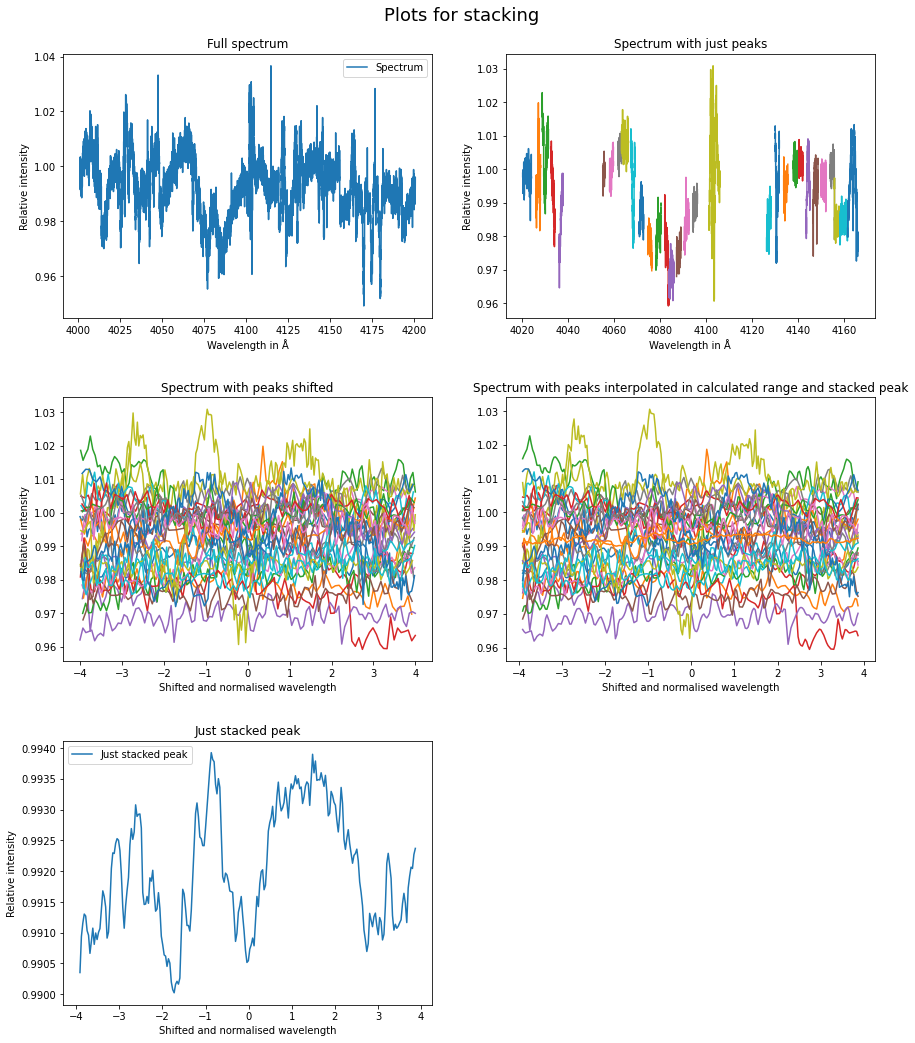

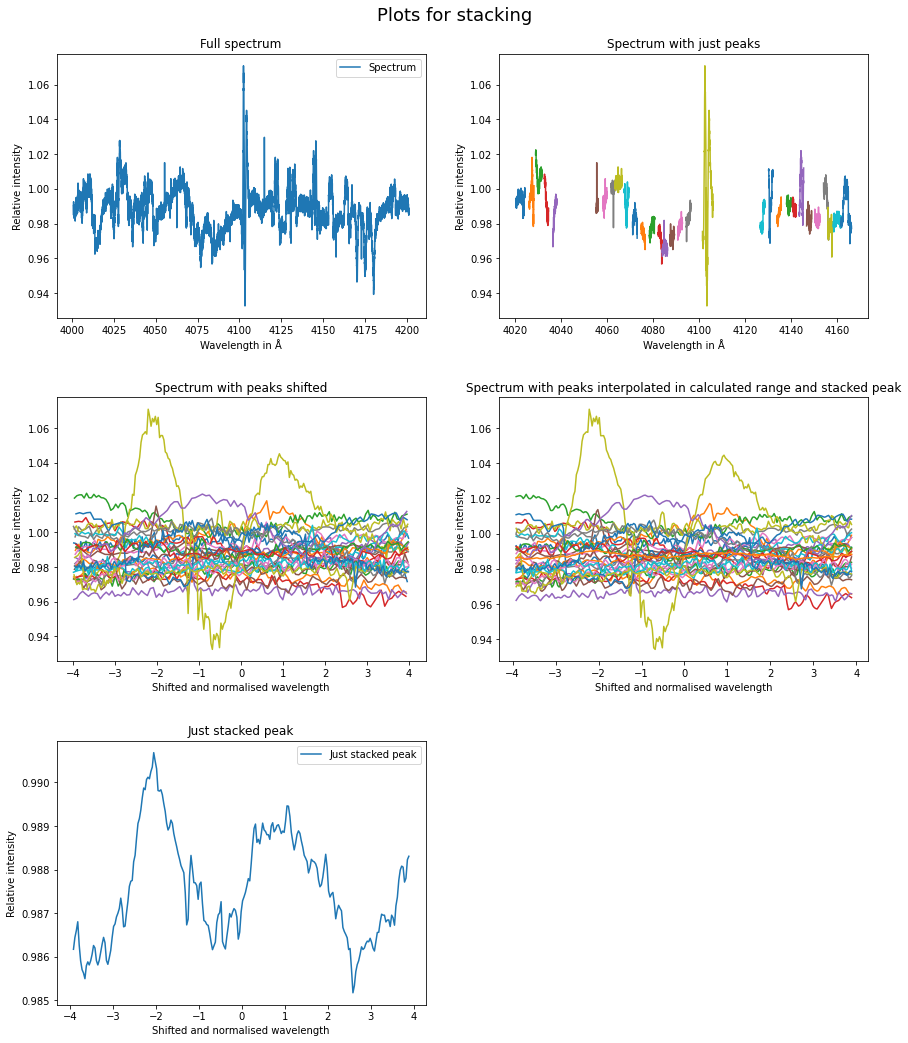

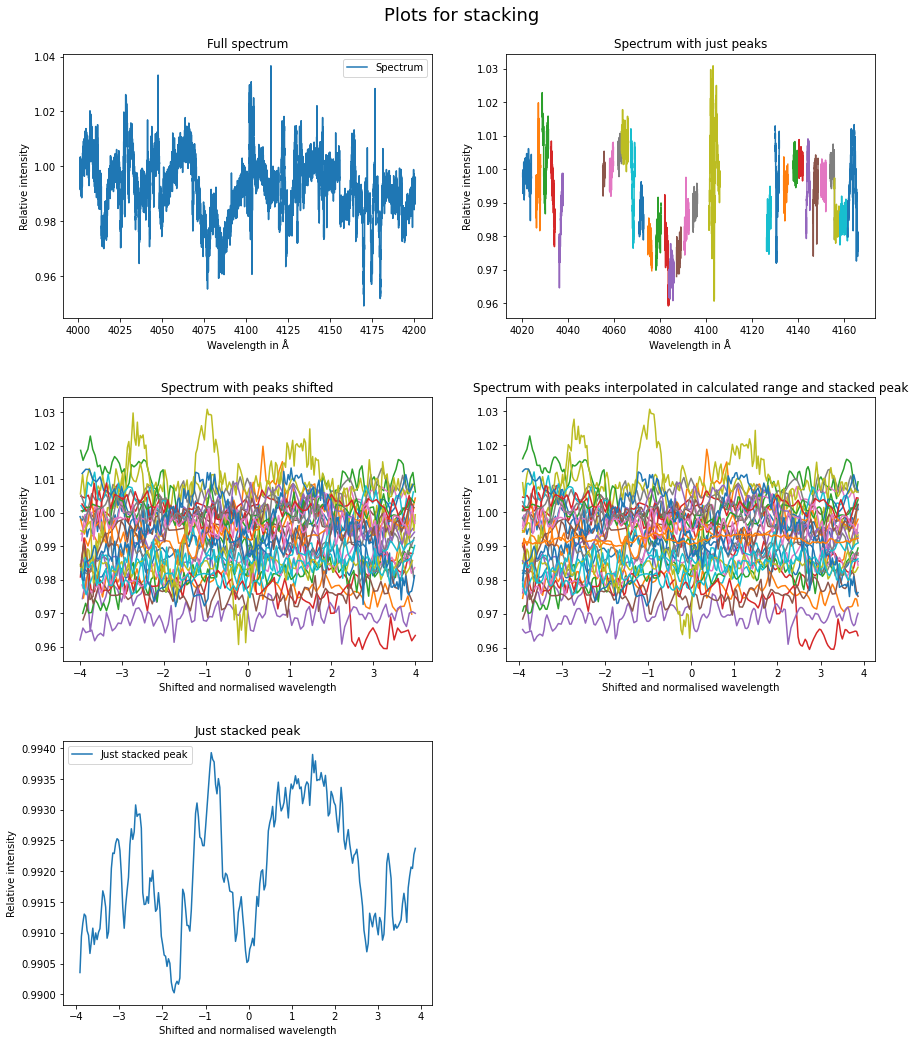

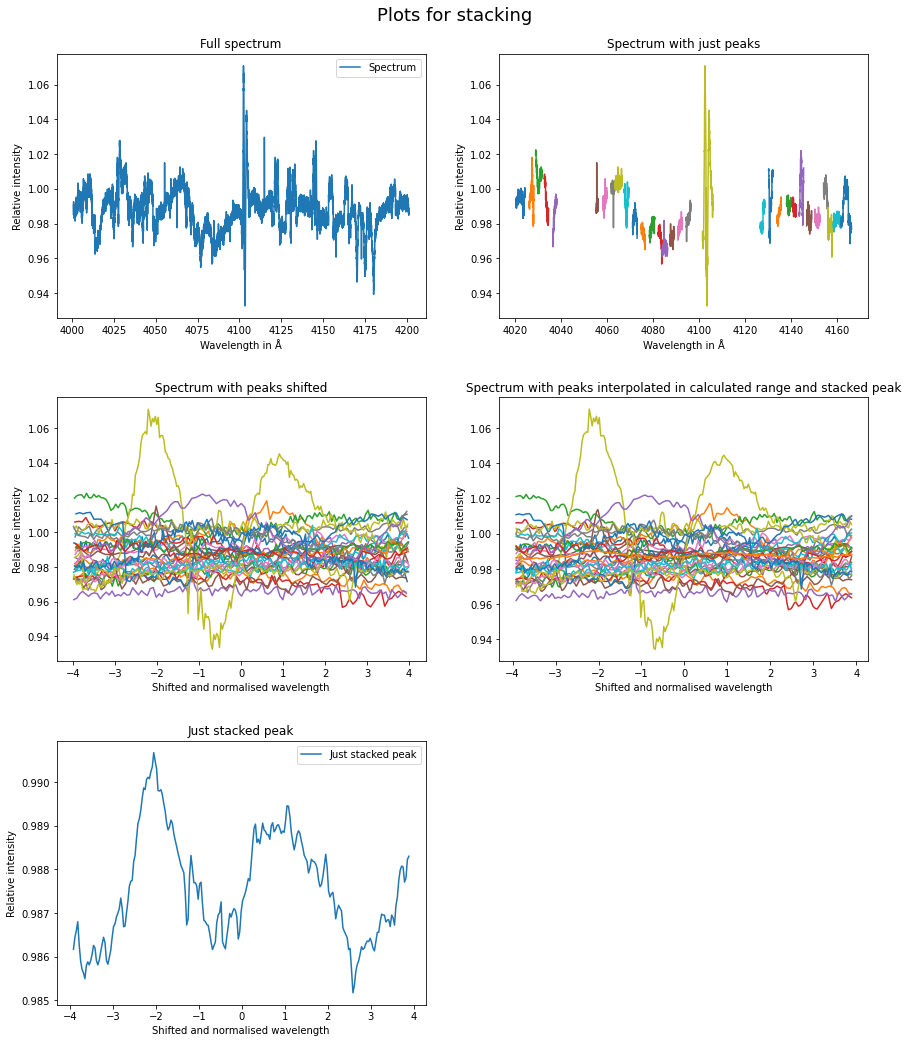

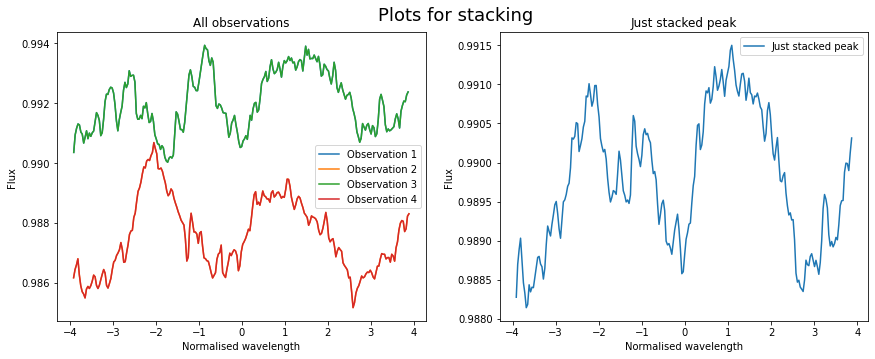

In [29]:
totalStack = np.empty(shape = len(datas)*len(datas[0]), dtype = object)
#print(totalStack.shape)

for it8 in range(len(datas)):
    for it9 in range(len(datas[it8])):
        totalStack[it8 * len(datas[it8]) + it9] = widthNormLinStacker(datas[it8][it9][1], stack_par)
        
#print(totalStack)
#print(stackRanges)
finalStacked = observationStacker(totalStack, [['Normalised wavelength', 'No units'], ['Flux', 'No units']])